In [1]:
## Importar librerias necesarias
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb

DIR_DATOS = """./"""
PARQUET_FILE = """datos_urgencia_consolidados.parquet"""
CSV_OUTPUT_FILE = """datos_urgencia_consolidados_agrupados.csv"""
duckdb.read_parquet("""datos_urgencia_consolidados.parquet""")

def find_peak_week(df, column,window = 5):
    if window % 2 == 0:
        print("please chooose an odd lenght window")
        return
    n = df.shape[0]
    #df_copy = df.copy()
    compare = df[column].drop([k for k in range(window)]).reset_index(drop= True) - df[column].drop([n-window + k for k in range(window)]).reset_index(drop= True)
    compare= compare.reset_index(drop= True)
    return np.argmax(compare)+window //2 

Gráfica correspondiente al año (2019)


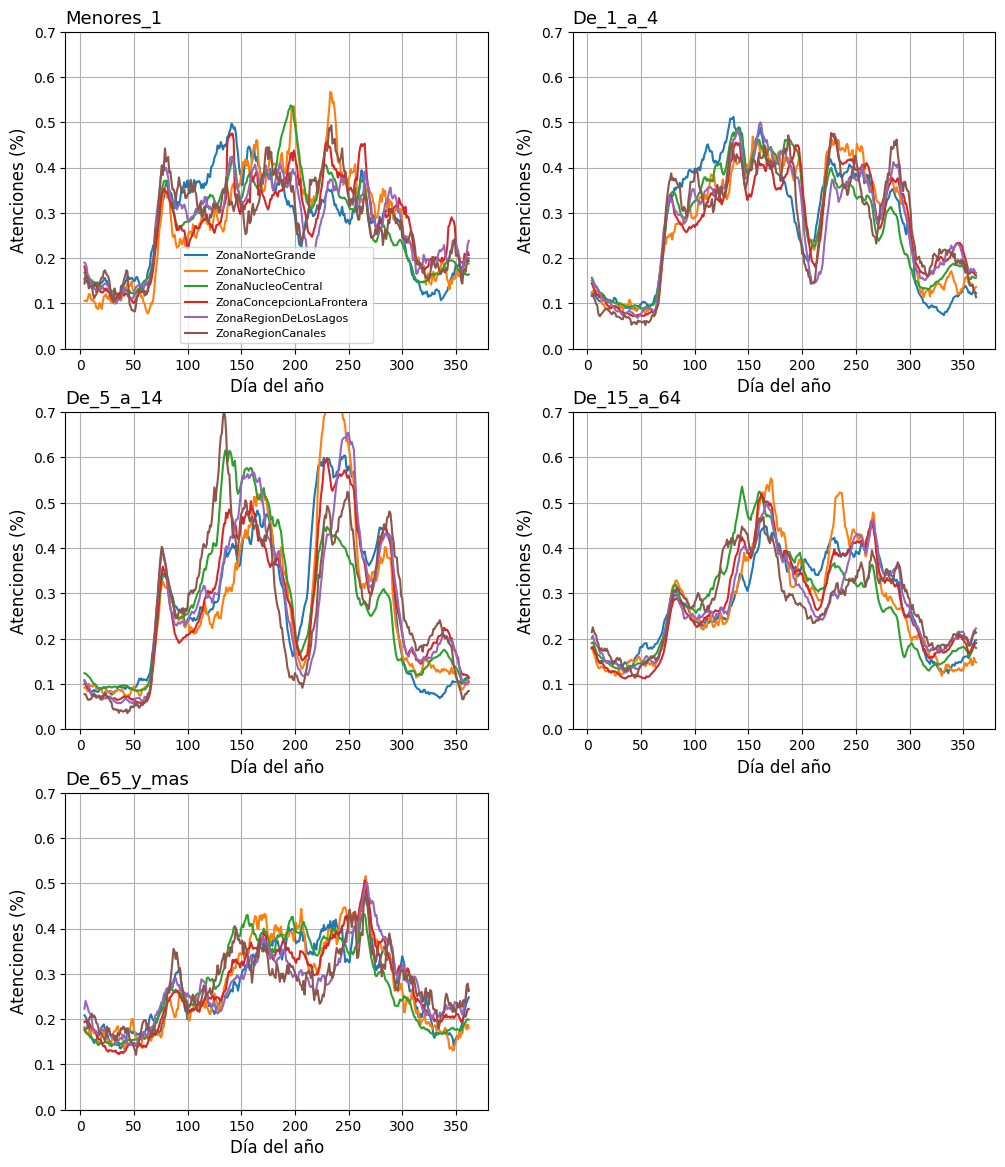

In [7]:
#Genera una comparación de las atenciones diarias correspondiente 
# a diferentes regiones geográficas. Las zonas están determinadas 
# por lo servicios de salud que las componen
# en los gráficos se muestra la información para diferentes grupos etarios
periodo = 365

zona_norte_grande = """(1,2,3)"""
zona_norte_chico = """(4,5)"""
zona_nucleo_central = """(6,7,8,9,10,11,12,13,14,15,16,17)"""
zona_concepcion_frontera = """(18,19,20,21,28,29)"""
zona_region_de_los_lagos = """(22,23,24)"""
zona_region_canales = """(25,26,33)"""

year = "(2019)"

print("Gráfica correspondiente al año " + year)

def common_filter_zona(zona):
    return """
FROM datos_urgencia_consolidados.parquet
where IdCausa in (3,4,5,6,10,11)
and year(strptime(fecha, '%d/%m/%Y')) in""" + year + """
--and year(strptime(fecha, '%d/%m/%Y')) in (2017,2018,2019,2022,2023)
--and year(strptime(fecha, '%d/%m/%Y')) in (2022,2023)
and CodigoDependencia in """ + zona +"""
--group by CodigoDependencia, fecha
group by zona, fecha
""" + """
having dayofyear(strptime(fecha, '%d/%m/%Y')) <= """+ str(periodo) + """
"""

#here CodigoDependencia indicates the "Servicio de Salud"
#to ignote the grouping by "region"  set "CodigoRegion" to a constant and remove it from the group by
df2 = duckdb.sql("""
select year(strptime(fecha, '%d/%m/%Y')) as year
--    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , 'ZonaNorteGrande' as zona
    , sum(Menores_1)  as Menores_1
    , sum(De_1_a_4)  as De_1_a_4
    , sum(De_5_a_14)  as De_5_a_14
    , sum(De_15_a_64)   as De_15_a_64
    , sum(De_65_y_mas) as De_65_y_mas
"""+ common_filter_zona(zona_norte_grande) + """
UNION
select year(strptime(fecha, '%d/%m/%Y')) as year
--    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , 'ZonaNorteChico' as zona
    , sum(Menores_1)  as Menores_1
    , sum(De_1_a_4)  as De_1_a_4
    , sum(De_5_a_14)  as De_5_a_14
    , sum(De_15_a_64)   as De_15_a_64
    , sum(De_65_y_mas) as De_65_y_mas
"""+ common_filter_zona(zona_norte_chico)  + """
UNION
select year(strptime(fecha, '%d/%m/%Y')) as year
--    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , 'ZonaNucleoCentral' as zona
    , sum(Menores_1)  as Menores_1
    , sum(De_1_a_4)  as De_1_a_4
    , sum(De_5_a_14)  as De_5_a_14
    , sum(De_15_a_64)   as De_15_a_64
    , sum(De_65_y_mas) as De_65_y_mas
"""+ common_filter_zona(zona_nucleo_central)  + """
UNION
select year(strptime(fecha, '%d/%m/%Y')) as year
--    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , 'ZonaConcepcionLaFrontera' as zona
    , sum(Menores_1)  as Menores_1
    , sum(De_1_a_4)  as De_1_a_4
    , sum(De_5_a_14)  as De_5_a_14
    , sum(De_15_a_64)   as De_15_a_64
    , sum(De_65_y_mas) as De_65_y_mas
"""+ common_filter_zona(zona_concepcion_frontera)  + """
UNION
select year(strptime(fecha, '%d/%m/%Y')) as year
--    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , 'ZonaRegionDeLosLagos' as zona
    , sum(Menores_1)  as Menores_1
    , sum(De_1_a_4)  as De_1_a_4
    , sum(De_5_a_14)  as De_5_a_14
    , sum(De_15_a_64)   as De_15_a_64
    , sum(De_65_y_mas) as De_65_y_mas
"""+ common_filter_zona(zona_region_de_los_lagos)  + """
UNION
select year(strptime(fecha, '%d/%m/%Y')) as year
--    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , 'ZonaRegionCanales' as zona
    , sum(Menores_1)  as Menores_1
    , sum(De_1_a_4)  as De_1_a_4
    , sum(De_5_a_14)  as De_5_a_14
    , sum(De_15_a_64)   as De_15_a_64
    , sum(De_65_y_mas) as De_65_y_mas
"""+ common_filter_zona(zona_region_canales) + """
""").df()

df2 = df2.sort_values(by=['zona','year','nrodia']).reset_index(drop = True)
df3 = pd.concat([df2[["zona","year","nrodia","Menores_1"]].rename(columns={"Menores_1":"atenciones"}).assign(grupo_etario = "Menores_1"),
df2[["zona","year","nrodia","De_1_a_4"]].rename(columns={"De_1_a_4":"atenciones"}).assign(grupo_etario = "De_1_a_4"),
df2[["zona","year","nrodia","De_5_a_14"]].rename(columns={"De_5_a_14":"atenciones"}).assign(grupo_etario = "De_5_a_14"),
df2[["zona","year","nrodia","De_15_a_64"]].rename(columns={"De_15_a_64":"atenciones"}).assign(grupo_etario = "De_15_a_64"),
df2[["zona","year","nrodia","De_65_y_mas"]].rename(columns={"De_65_y_mas":"atenciones"}).assign(grupo_etario = "De_65_y_mas")
])

# ILUSTRACIÓN 1 ATENCIONES DIARIAS DE URGENCIA PARA 
# CADA DÍA DEL AÑO CORRESPONDIENTES AL PERIODO 2017 -2023 para diferentes zonas geográficas 
fig = plt.figure(figsize = (12,14))
grupo_etario_list=["Menores_1","De_1_a_4","De_5_a_14","De_15_a_64","De_65_y_mas"]

for k in range(5):
    df4 =df3[df3["grupo_etario"]==grupo_etario_list[k]]
    ax = fig.add_subplot(3,2,k+1) 
    df_dict = {key[0]: d for key, d in df4[['zona','year','nrodia','atenciones']].groupby(['zona'])}
    #targets = list(df_dict.keys())
    targets = ["ZonaNorteGrande",
               "ZonaNorteChico",
               "ZonaNucleoCentral",
               "ZonaConcepcionLaFrontera",
               "ZonaRegionDeLosLagos",
               "ZonaRegionCanales"]
    ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
    for key in targets:
        plt.plot(df_dict[key]['nrodia'],100*df_dict[key]['atenciones'].rolling(7,center=True).mean()/float(sum(df_dict[key]['atenciones'])) )
    if k==0:
        plt.legend(targets,loc='lower center',fontsize = 8 )
        #plt.legend(targets,loc='upper right',fontsize = 8 )
    ax.set_ylim(ymin=0)
    ax.set_ylim(ymax=0.7)
    ax.grid()
    ax.set_title(str(grupo_etario_list[k]) , fontsize = 13, loc='left')
    ax.set_xlabel('Día del año', fontsize = 12)
    ax.set_ylabel('Atenciones (%)', fontsize = 12)

